In [1]:
##############################################################################
# blosc2_grok: Grok (JPEG2000 codec) plugin for Blosc2
#
# Copyright (c) 2023  Blosc Development Team <blosc@blosc.org>
# https://blosc.org
# License: GNU Affero General Public License v3.0 (see LICENSE.txt)
##############################################################################

"""
Benchmark for compressing blocked images with grok codec.

Data can be downloaded from: http://www.silx.org/pub/leaps-innov/sparse_image_stack.h5
"""

'\nBenchmark for compressing blocked images with grok codec.\n\nData can be downloaded from: http://www.silx.org/pub/leaps-innov/sparse_image_stack.h5\n'

In [2]:
import h5py
import hdf5plugin
import blosc2
import blosc2_grok
import numpy as np
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
import matplotlib.pyplot as plt
from time import time
import itertools
print(f"Blosc2 version: {blosc2.__version__}")
print(f"blosc2_grok version: {blosc2_grok.__version__}")

Blosc2 version: 2.5.2.dev0
blosc2_grok version: 0.2.3


In [3]:
# Params for the frame iterator
verbose = False
all_frames = False
meas = {}  # dictionary for storing the measurements
filters = ("shuffle", "bitshuffle", "bytedelta", "noshuffle")
dtype = "uint16"  # None if no cast is to be done
#dtype = None

In [4]:
# Open the dataset
data_dir = '/Users/faltet/Downloads/'
f = h5py.File(f'{data_dir}/sparse_image_stack.h5', 'r')
dset = f['entry_0000/ESRF-ID11/eiger/data']
if all_frames:
    nframes = dset.shape[0]
else:
    nframes = 1
#images_per_chunk = 16
images_per_chunk = 8
nimages = images_per_chunk
blocks = (1, dset.shape[1], dset.shape[2])
print(f"Compressing dataset of {dset.shape} images ...")
print(f"Datatype: {dset.dtype}")

Compressing dataset of (7200, 2162, 2068) images ...
Datatype: uint32


In [5]:
def iter_images(verbose=False):
    # ret = itertools.chain([1], range(4, images_per_chunk + 1, 4))
    ret = range(8, images_per_chunk + 1, 4)
    if verbose:
        ret = tqdm(ret)
    return ret

In [6]:
for shuffle in filters:
    if shuffle == "bytedelta":
        shuffle_mode = blosc2.Filter.BYTEDELTA
    elif shuffle == "shuffle":
        shuffle_mode = blosc2.Filter.SHUFFLE
    elif shuffle == "bitshuffle":
        shuffle_mode = blosc2.Filter.BITSHUFFLE
    else:
        shuffle_mode = blosc2.Filter.NOFILTER
        
    # Compress the dataset with different compression ratios
    quality_mode = f"{shuffle}"
    print(f"Quality mode: {quality_mode}")
    ssims = []
    cratios = []
    times = []
    dtimes= []
    range_vals = list(range(0, -4, -1))
    range_vals_str = "range(0, -4, -1)"
    for nbits in range_vals:
        if verbose:
            print(f"Compressing with itrunc={nbits}x ...")
        cparams2 = blosc2.cparams_dflts.copy()
        cparams2['codec'] = blosc2.Codec.ZSTD
        cparams2['clevel'] = 5
        filter = blosc2.Filter.INT_TRUNC if nbits != 0 else blosc2.Filter.NOFILTER
        cparams2['filters'] = [filter, shuffle_mode]
        cparams2['filters_meta'] = [nbits, 0]
        #cparams2['filters'] = [shuffle_mode]
        #cparams2['filters_meta'] = [0]
    
        # Iterate over the frames
        iter_frames = tqdm(range(0, nframes, nimages)) if verbose else range(0, nframes, nimages)
        for i in iter_frames:
            im = dset[i:i+nimages, ...]
            # Transform the numpy array into a blosc2 array. This is where compression happens.
            t0 = time()
            if dtype is not None:
                im = im.astype(dtype)
            chunks = (nimages, dset.shape[1], dset.shape[2])
            b2im = blosc2.asarray(im, chunks=chunks, blocks=blocks, cparams=cparams2)
            if i == 0:
                times.append(time() - t0)
                cratio = b2im.schunk.cratio if dtype is None else b2im.schunk.cratio * 2
                cratios.append(cratio)
                # Compare with the original image
                t0 = time()
                im2 = b2im[:]
                dtimes.append(time() - t0)
                ssim_ = ssim(im[0], im2[0], data_range=im[0].max() - im[0].min())
                ssims.append(ssim_)
        if verbose:
            print(f"SSIM: {ssim_}")
    meas[quality_mode] = {'ssims': ssims, 'cratios': cratios, 'times': times, 'dtimes': dtimes}

Quality mode: shuffle
Quality mode: bitshuffle
Quality mode: bytedelta
Quality mode: noshuffle


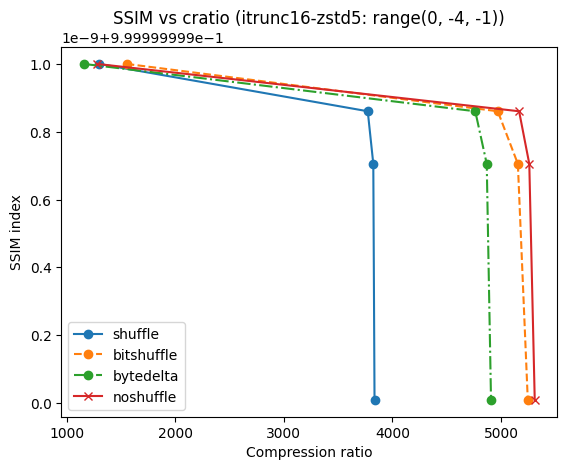

In [7]:
for quality_mode in filters:
    if quality_mode == "noshuffle":
        marker = 'x-'
    elif quality_mode == "shuffle":
        marker = 'o-'
    elif quality_mode == "bitshuffle":
        marker = 'o--'
    else:
        marker = 'o-.'
    plt.plot(meas[quality_mode]['cratios'], meas[quality_mode]['ssims'], marker, label=quality_mode)
itrunc = "itrunc32" if dtype is None else "itrunc16"
plt.title(f'SSIM vs cratio ({itrunc}-zstd5: {range_vals_str})')
plt.xlabel('Compression ratio')
plt.ylabel('SSIM index')
delta = 1e-9
#plt.ylim(top = 1 + delta / 10)
plt.legend()

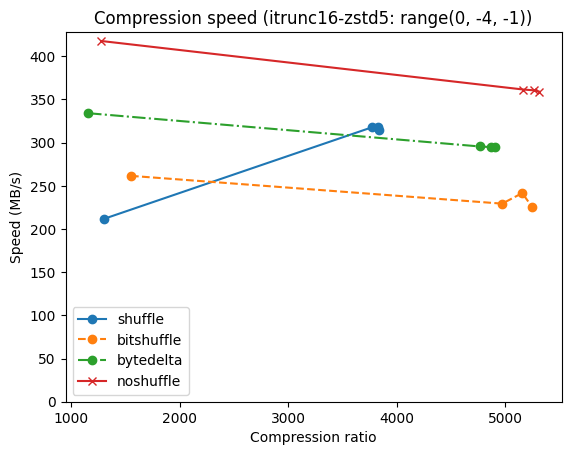

In [8]:
chunks = (images_per_chunk, dset.shape[1], dset.shape[2])
sizeMB = np.prod(chunks) / 2**20
for quality_mode in filters:
    if quality_mode == "noshuffle":
        marker = 'x-'
    elif quality_mode == "shuffle":
        marker = 'o-'
    elif quality_mode == "bitshuffle":
        marker = 'o--'
    else:
        marker = 'o-.'
    plt.plot(meas[quality_mode]['cratios'], sizeMB / meas[quality_mode]['times'], marker, label=quality_mode)

plt.title(f'Compression speed ({itrunc}-zstd5: {range_vals_str})')
plt.xlabel('Compression ratio')
plt.ylabel('Speed (MB/s)')
plt.ylim(0)
plt.legend()

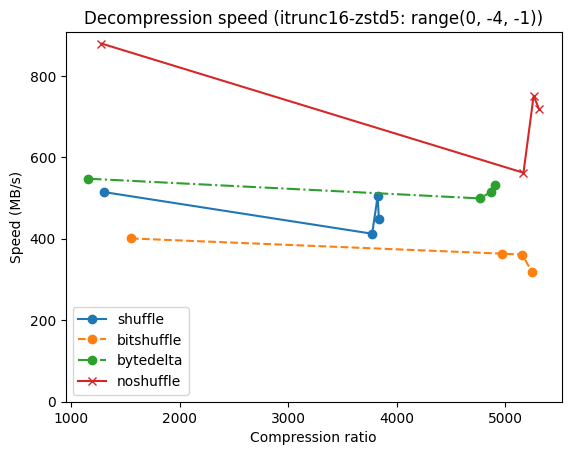

In [9]:
chunks = (images_per_chunk, dset.shape[1], dset.shape[2])
sizeMB = np.prod(chunks) / 2**20
for quality_mode in filters:
    if quality_mode == "noshuffle":
        marker = 'x-'
    elif quality_mode == "shuffle":
        marker = 'o-'
    elif quality_mode == "bitshuffle":
        marker = 'o--'
    else:
        marker = 'o-.'
    plt.plot(meas[quality_mode]['cratios'], sizeMB / meas[quality_mode]['dtimes'], marker, label=quality_mode)

plt.title(f'Decompression speed ({itrunc}-zstd5: {range_vals_str})')
plt.xlabel('Compression ratio')
plt.ylabel('Speed (MB/s)')
plt.ylim(0)
plt.legend()